In [1]:
from FlowControl import add_to_class
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame,Series
from matplotlib import cm

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

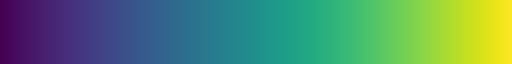

In [3]:
viridis = cm.viridis
viridis

<h1>K-Nearest-Neighbours algorithm</h1>

KNN algorithm is a supervised, non-parametric machine learning algorithm. It works on the basis of analysis of distance between given point and its $k$-nearest neighbours. Analysis result is strongly related with metric for which we calculate the distance.

1. Manhattan metric:
$$
d_{Manhattan}(\vec{x}^{(i)},\vec{x}^{(j)}) = \sum_{k=1}|x_{k}^{(i)} - x_{k}^{(j)}| 
$$
2. Minkowski p-metric:
$$
d_{Minkowski}(\vec{x}^{(i)},\vec{x}^{(j)}) = \Big[\sum_{k=1}|x_{k}^{(i)} - x_{k}^{(j)}|^{p}\Big]^{1/p} 
$$
3. Euclidean p-metric:
$$
d_{Euclidean}(\vec{x}^{(i)},\vec{x}^{(j)}) = \sqrt{\sum_{k=1}(x_{k}^{(i)} - x_{k}^{(j)})^{2}}
$$
3. Min Manhattan p-metric:
$$
d_{Min}(\vec{x}^{(i)},\vec{x}^{(j)}) = \text{min}_{k}|x_{k}^{(i)} - x_{k}^{(j)}|
$$

In [4]:
class KNN:
    def __init__(self):
        pass

    def fit(self,X_data,y_data,k):
        raise NotImplementedError

    def count_nn(self,y_nn):
        raise NotImplementedError
    
    def distance(self,X_data,metrics = "Euclidean", p = 2):
        raise NotImplementedError
    
    def predict(self,X_data,metrics = "Euclidean",**kwargs):
        raise NotImplementedError

In [5]:
@add_to_class(KNN)
def fit(self,X_data,y_data,k):
    self.X_data = X_data
    self.y_data = y_data
    self.k = k

@add_to_class(KNN)
def predict(self,X_data,metrics = "Euclidean",**kwargs):
    p_ = kwargs.get("p",2)
    dist_arr = self.distance(X_data,metrics = metrics, p = p_) 
    # distance array should be of shape (m,n)
    # where m is number of training points -> number of distances for given element of X_data
    # n is number of points to predict -> 0-th element of X_data.shape
    y_nn = self.y_data[np.argsort(dist_arr,axis = 0)[:self.k,:]]
    return self.count_nn(y_nn)

@add_to_class(KNN)
def count_nn(self,y_nn):
    y_ans = []
    for i in range(y_nn.shape[1]):
        distinct,counts = np.unique(y_nn[:,i],return_counts=True)
        y_ans.append(distinct[np.argmax(counts)])
    return np.array(y_ans)

@add_to_class(KNN)
def distance(self,X_data,metrics = "Euclidean", p = 2):
    Delta = self.X_data[:,:,np.newaxis] - X_data.T[np.newaxis,:,:]
    if metrics == "Manhattan":
        return np.sum(np.abs(Delta),axis = 1)
    elif metrics == "Minkowski":
        return np.sum(np.abs(Delta)**p,axis = 1) ** (1/p)
    elif metrics == "MinManhattan":
        return np.max(np.abs(Delta),axis = 1)
    else:
        return np.sqrt(np.sum(Delta**2,axis = 1))
    



<h2>Synthetic dataset</h2>

In [6]:
def generate_k_clusters(k,seed):
    rng = np.random.default_rng(seed)
    data_sets = []
    y_sets = []
    total_size = 0
    for i in range(k):
        mu = rng.uniform(size = 2)*1.5
        stds = rng.uniform(size = 2) / 3
        size = rng.integers(50)+50
        total_size += size
        data_sets.append(np.array(
            [rng.normal(loc = mu[0],scale = stds[0],size = size),
            rng.normal(loc = mu[1],scale = stds[1],size = size)]
        ).T)
        y_sets.append(np.ones(size) * i)
    inds = rng.permutation(total_size)
    return np.vstack(data_sets)[inds],np.hstack(y_sets)[inds]

def plot_data_points(X_data,y_data,ax,title = "KNN classification"):
    k = len(np.unique(y_data))
    for i in range(k):
        inds = (y_data == i)
        ax.scatter(X_data[inds,0],X_data[inds,1],color = viridis(i/k),label = f"class: {i}",alpha=0.9,s = 5,marker = "^")
    ax.set_xlabel(r"$x_{0}$")
    ax.set_ylabel(r"$x_{1}$")
    ax.set_title(title)
    ax.grid()

In [7]:
k = 4
X_data,y_data = generate_k_clusters(k,45)

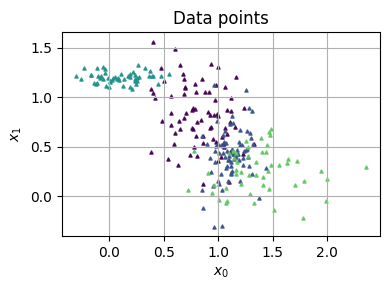

In [8]:
fig = plt.figure(figsize = (4,3))
ax = fig.add_subplot()

plot_data_points(X_data,y_data,ax,title = "Data points")

plt.tight_layout()
plt.show()

In [9]:
x_ = np.arange(X_data[:,0].min() - 0.1,X_data[:,0].max() + 0.1,0.01)
y_ = np.arange(X_data[:,1].min() - 0.1,X_data[:,1].max() + 0.1,0.01)

print("number of x points: ",len(x_))
print("number of y points: ",len(y_))

x,y = np.meshgrid(x_,y_)
X_test_tot = np.stack((x,y),axis = 2)

X_test_tot_fl = X_test_tot.reshape(-1,2)

number of x points:  286
number of y points:  208


In [10]:
def fit_to_mesh(k,metrics,ax):
    model_knn = KNN()
    model_knn.fit(X_data,y_data,k)
    y_pred = model_knn.predict(X_test_tot_fl,metrics=metrics,p = 4) 
    y_pred_tot = y_pred.reshape(len(y_),len(x_))
    ax.imshow(y_pred_tot,extent=[x_.min(),x_.max(),y_.min(),y_.max()],origin="lower",alpha = 0.3)

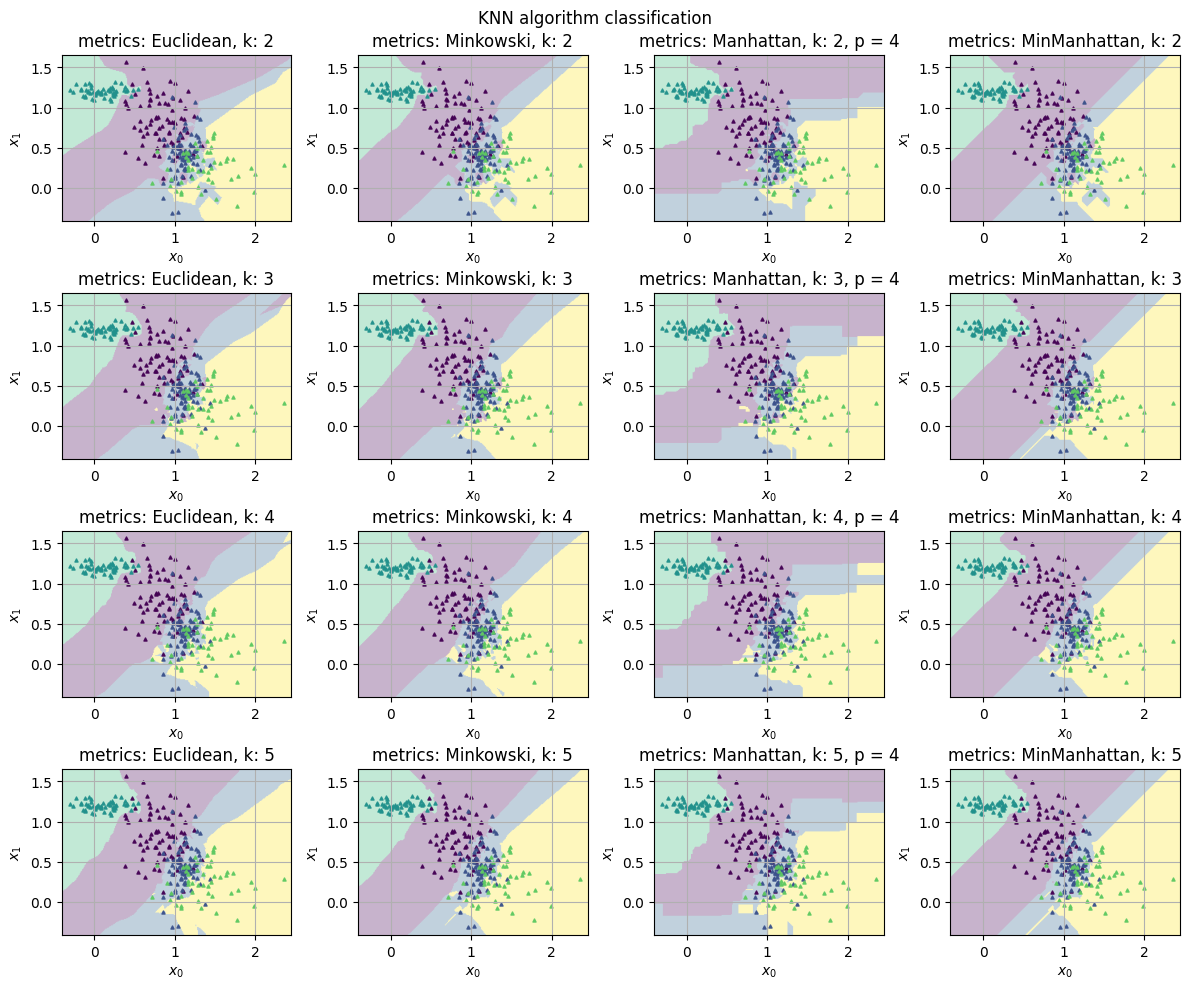

In [11]:
fig = plt.figure(figsize=(12,10))
fig.suptitle("KNN algorithm classification")

metrics_s = ["Euclidean","Minkowski","Manhattan","MinManhattan"]
k_s = [2,3,4,5]

for i,met in enumerate(metrics_s):
    for j,k_ in enumerate(k_s):
        ax = fig.add_subplot(len(k_s),len(metrics_s),j * len(metrics_s) + i + 1)
        plot_data_points(X_data,y_data,ax,title = f"metrics: {met}, k: {k_}" + (", p = 4" if met == "Manhattan" else ""))
        fit_to_mesh(k_,met,ax)
plt.tight_layout()
plt.show()